In [1]:
import glob
import os
import warnings
warnings.filterwarnings("ignore")

import cftime
import dask
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

import numpy as np
import pandas as pd
import xarray as xr

from scipy import stats
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

In [2]:
### import some analysis functions we wrote for this project
import sys ; sys.path.append("../../")
import sys ; sys.path.append("..")
import sys ; sys.path.append("../whit/")
from ppe_analysis.analysis import *

In [3]:
# Setup your PBSCluster
import dask
from dask.distributed import Client
from dask_jobqueue import PBSCluster

ncores=1
nmem='25GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='03:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(30)

# Setup your client
client = Client(cluster)

In [4]:
client.cluster

In [5]:
def get_files(htape,yr0=1850,yr1=2014):
    d='/glade/campaign/asp/djk2120/PPEn11/transient/hist/'

    #find all files
    fs   = np.array(sorted(glob.glob(d+'*'+htape+'*')))
    yrs  = np.array([int(f.split(htape)[1][1:5]) for f in fs])
    keys = np.array([f.split('.clm2')[0][-7:] for f in fs])

    #bump back yr0, if needed
    uyrs=np.unique(yrs)
    dy=uyrs[1]-yrs[0]
    yr0=dy*int(yr0/dy)
    
    #find index to subset files
    ix   = (yrs>=yr0)&(yrs<=yr1)
    yrs  = yrs[ix]
    keys = keys[ix]

    #subset and reshape files
    ny=np.sum(keys=='LHC0000')
    nens = int(len(keys)/ny)
    files = fs[ix].reshape([nens,ny])

    #convert to list of lists
    files = [list(f) for f in files]
    
    return files,np.unique(keys)

In [6]:
def add_params(ds,df,keys):
    mems=df['member'].values
    ix1=0*mems==1
    for key in keys:
        ix1=(ix1)|(mems==key)

    nens=len(ds.ens)    
    ix2=0*np.arange(nens)==1
    for mem in mems:
        ix2=(ix2)|(ds.key==mem)


    params=[]    
    for p in df.keys():
        if p!='member':
            x=xr.DataArray(np.nan+np.zeros(nens),dims='ens')
            x[ix2]=df[p][ix1]
            ds[p]=x
            params.append(p)
    ds['params']=xr.DataArray(params,dims='param')

In [7]:
def get_ds(dvs,htape,yr0=1850,yr1=2014,dropdef=False):
    
    def preprocess(ds):
        return ds[dvs]
    
    #read in the data
    files,keys = get_files(htape,yr0,yr1)
    if dropdef:
        files = files[1:]
        keys  = keys[1:]
    
    ds = xr.open_mfdataset(files,combine='nested',concat_dim=['ens','time'],
                       parallel=True,preprocess=preprocess)
    
    #fix the time dimension, if needed
    yr0=str(ds['time.year'].values[0])
    if (htape=='h0')|(htape=='h1'):
        ds['time']=xr.cftime_range(yr0,periods=len(ds.time),freq='MS')
    
    #add some param info, etc.
    df=pd.read_csv('/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt')
    ds['key']=xr.DataArray(keys,dims=['ens'])
    add_params(ds,df,keys)
    
    #add landarea info
    la_file = '/glade/u/home/djk2120/clm5ppe/pyth/sparsegrid_landarea.nc'
    la = xr.open_dataset(la_file).landarea  #km2
    ds['la'] = la
    
    #add some extra variables, e.g. lat/lon
    tmp = xr.open_dataset(files[0][0])
    for v in tmp.data_vars:
        if 'time' not in tmp[v].dims:
            ds[v]=tmp[v]  
    
    return ds

In [8]:
def gmean(da,la,cf=1):
    #global mean
    xg=cf/la.sum()*(la*da).sum(dim='gridcell').compute()
    return xg

def amean(da,cf=1):
    #annual mean
    m  = da['time.daysinmonth']
    xa = cf/365*(m*da).groupby('time.year').sum().compute()
    return xa

whit = xr.open_dataset('./whit/whitkey.nc')
def bmean(da,la):
    g=whit.biome
    xb=1/la.groupby(g).sum()*(la*da).groupby(g).sum(dim='gridcell').compute()
    xb['biome_name']=xr.DataArray(whit.biome_name.values,dims='biome')
    return xb

### Load PPE dataset

In [9]:
#read in PPE ensemble
dvs = ['TLAI']
ds = get_ds(dvs,'h0',2000,2003)
ds = ds.sel(time=slice('2000-01-01', '2003-12-01'))

In [21]:
la = ds.la

In [25]:
PPE_TLAI_gmean = gmean(amean(ds['TLAI']).mean(dim='year'),la).compute()

### Load SP dataset

In [32]:
in_file = '/glade/scratch/linnia/LAI_SP_ctsm51d115/run/LAI_SP_ctsm51d115.clm2.h0.2000-01-01-00000.nc'
SP = xr.open_dataset(in_file) # SP on full grid

#f='/glade/campaign/asp/djk2120/PPEn11/CTL2010/hist/PPEn08_CTL2010_OAAT0000.clm2.h0.2005-02-01-00000.nc'
f='/glade/campaign/asp/djk2120/PPEn11/transient/hist/PPEn11_transient_LHC0500.clm2.h0.2010-02-01-00000.nc'
ds2=xr.open_dataset(f)
ivals=ds2.grid1d_ixy.astype(int)-1  #python indexing starts at 0
jvals=ds2.grid1d_jxy.astype(int)-1
SP_sg = SP.TLAI[:,jvals,ivals] # SP on sparse grid

In [33]:
SP_TLAI_am_sg = amean(SP_sg).mean(dim='year').compute()
SP_TLAI_am_sg

<xarray.DataArray (gridcell: 400)>
array([1.27005860e+00, 6.58765606e-01, 9.32744504e-01, 3.76916863e-01,
       1.83917691e-01, 1.89705132e+00, 2.47910432e+00, 2.93484190e+00,
       2.23594881e+00, 3.61425961e+00, 1.23184860e+00, 1.77424268e+00,
       5.62130412e-01, 5.75047212e-01, 4.11417916e-01, 2.61800717e-01,
       1.48202569e+00, 1.43233649e-01, 1.97562535e-01, 3.49036726e-01,
       7.22641368e-01, 2.34529572e+00, 6.09982534e-02, 2.69286174e-01,
       6.84705658e-01, 9.79662433e-01, 6.81715167e-01, 1.74316655e-01,
       1.89182011e-01, 5.43092347e-02, 1.12644932e+00, 1.54429656e-01,
       5.82601281e-01, 1.59761329e+00, 2.56313930e+00, 1.61976521e-01,
       1.31577655e+00, 1.90203217e+00, 1.40816168e+00, 1.45474581e+00,
       5.46789584e-01, 9.11463331e-01, 3.08061723e-01, 1.04146128e-01,
       2.20901427e+00, 1.66812457e+00, 4.92158082e-01, 1.41135425e+00,
       2.79025499e+00, 1.17557680e+00, 1.02046296e+00, 1.63536338e+00,
       4.33814031e-01, 5.71098745e-01, 1.35340687e+00, 2.48635229e+00,
       1.22492387e+00, 1.19191002e+00, 2.24635070e-01, 4.24211264e+00,
       3.72859537e+00, 2.10587979e+00, 1.35480246e+00, 1.75756354e+00,
       2.01217196e+00, 4.09871595e+00, 4.98373121e+00, 2.08961630e+00,
       2.68730384e+00, 2.48223616e+00, 4.97779951e+00, 1.54255494e+00,
       1.93582873e+00, 2.37833209e+00, 1.40241297e+00, 4.44349932e+00,
       0.00000000e+00, 5.08978999e+00, 1.97544555e+00, 1.31145614e+00,
...
       2.67445095e-03, 9.52825991e-01, 1.24418628e+00, 8.48881999e-01,
       2.16102109e-01, 2.60228784e-01, 3.95702544e-01, 3.70385115e-01,
       2.29356871e-01, 5.45894016e-01, 9.41355012e-01, 3.62169910e-01,
       5.69865976e-02, 2.17591945e-02, 7.80764113e-01, 6.68317691e-01,
       7.05893634e-01, 3.36570794e-01, 3.34766976e-01, 2.67949797e-01,
       2.45434547e-01, 3.89205670e-01, 4.84493741e-01, 4.80353629e-01,
       1.68604565e-01, 6.82226258e-02, 2.28681580e-02, 3.78854318e-02,
       5.50186113e-05, 3.38092456e-01, 2.47548187e-01, 2.28280905e-01,
       3.40427937e-01, 3.04002646e-01, 1.83041504e-01, 3.36992913e-02,
       1.88938462e-02, 0.00000000e+00, 6.14540353e-01, 4.65184054e-01,
       0.00000000e+00, 1.67699197e-01, 9.41996931e-02, 1.75228945e-01,
       2.08833050e-02, 0.00000000e+00, 1.19194371e-01, 1.99840964e-01,
       1.84840370e-01, 1.97029482e-01, 1.22609474e-02, 0.00000000e+00,
       1.35281325e-02, 2.15523453e-02, 1.51703392e-01, 1.59805453e-01,
       9.08259546e-02, 2.61945746e-03, 7.73191326e-04, 8.98893737e-02,
       8.22664643e-03, 7.00295229e-03, 9.61255187e-03, 4.93730383e-05,
       0.00000000e+00, 0.00000000e+00, 1.60326643e-03, 5.11432249e-03,
       0.00000000e+00, 7.09092370e-05, 2.78969518e-03, 3.50213068e-04,
       2.27828331e-04, 7.31795039e-03, 5.35414022e-04, 1.91013958e-03,
       9.57801403e-03, 9.31748197e-03, 7.05192467e-02, 1.91289750e-03])
Coordinates:
    lon      (gridcell) float32 292.5 287.5 302.5 287.5 ... 307.5 325.0 340.0
    lat      (gridcell) float32 -55.89 -54.0 -52.11 -48.32 ... 82.42 82.42 82.42
Dimensions without coordinates: gridcell

In [34]:
SP_TLAI_gm_am_sg = gmean(amean(SP_sg),la)

In [35]:
SP_TLAI_gm_am_sg

<xarray.DataArray (year: 1)>
array([1.1639474])
Coordinates:
  * year     (year) int64 2000

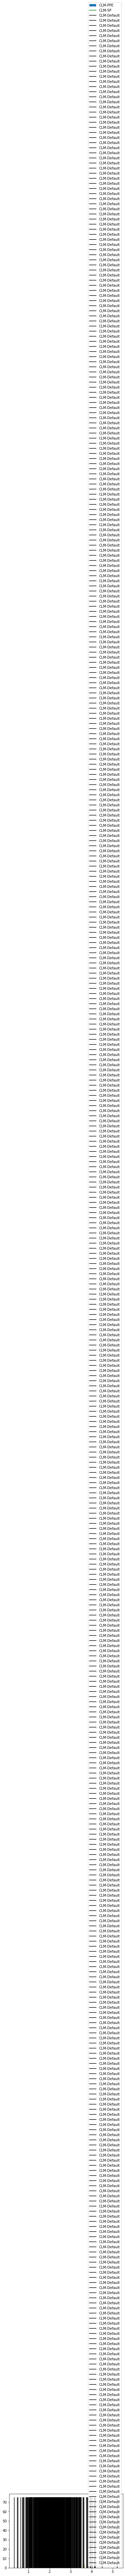

In [36]:
plt.hist(PPE_TLAI_gmean,bins=20,label='CLM-PPE')
plt.plot([SP_TLAI_gm_am_sg.values,SP_TLAI_gm_am_sg.values],[0,75],c='green',label='CLM-SP')
plt.plot([PPE_TLAI_gmean[0].values,PPE_TLAI_gmean[0].values],[0,75],c='k',label='CLM-Default')
plt.legend()